In [1]:
import os
import random
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import wandb

# save weights and biases api key to .env file in project directory
assert os.getenv('WANDB_API_KEY')
assert torch.cuda.is_available()

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)  # noqa: NPY002
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shane-kercheval. Use `wandb login --relogin` to force relogin


True

In [3]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(y.astype(int).values, dtype=torch.long)

# need to make this dynamic based on Fully Connected vs Convolutional
# Reshape data to have channel dimension
# MNIST images are 28x28, so we reshape them to [batch_size, 1, 28, 28]
x = x.reshape(-1, 1, 28, 28)

# 80% train; 10% validation; 10% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(f"Training set  : X-{x_train.shape}, y-{y_train.shape}")
print(f"Validation set: X-{x_val.shape}, y-{y_val.shape}")
print(f"Test set      : X-{x_test.shape}, y-{y_test.shape}")

Training set  : X-torch.Size([56000, 1, 28, 28]), y-torch.Size([56000])
Validation set: X-torch.Size([7000, 1, 28, 28]), y-torch.Size([7000])
Test set      : X-torch.Size([7000, 1, 28, 28]), y-torch.Size([7000])


In [4]:
class ConvNet(nn.Module):
    """Convolutional neural network (two convolutional layers)."""

    def __init__(self, kernels: list, classes: int = 10):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * kernels[-1], classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        return self.fc(out)

In [5]:
def make_loader(x: torch.tensor, y: torch.tensor, batch_size: int) -> DataLoader:
    """Make a DataLoader from a given dataset."""
    return DataLoader(
        dataset=TensorDataset(x, y),
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=2,
    )


def make(config: dict) -> tuple:
    """Make the model, data, and optimization objects."""
    # Make the data
    train_loader = make_loader(x_train, y_train, batch_size=config.batch_size)
    validation_loader = make_loader(x_val, y_val, batch_size=config.batch_size)
    test_loader = make_loader(x_test, y_test, batch_size=config.batch_size)

    # Make the model
    model = ConvNet(config.kernels, config.classes).to(DEVICE)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    return (
        model,
        train_loader,
        validation_loader,
        test_loader,
        criterion,
        optimizer,
    )


def train_log(training_loss: float, validation_loss: float, example_ct: int, epoch: int) -> None:
    """Logs loss to the console and wandb."""
    # Where the magic happens
    wandb.log(
        {
            'epoch': epoch,
            'training_loss': training_loss,
            'validation_loss': validation_loss,
        },
        step=example_ct,
    )
    print(
        f"Training/Validation Loss after {str(example_ct).zfill(5)} examples: ",
        f"{training_loss:.3f} | {validation_loss:.3f}",
    )


def calculate_average_loss(
        data_loader: DataLoader,
        model: nn.Module,
        loss_func: callable) -> float:
    """Calculates the average loss over a dataset."""
    running_loss = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)  # noqa: PLW2901
            loss = loss_func(model(x), y)
            # weighted average of the loss adjusted for the batch size
            running_loss += loss.item() * x.shape[0]
            total_samples += x.shape[0]
    return running_loss / total_samples


def train(
        model: nn.Module,
        train_loader: DataLoader,
        validation_loader: DataLoader,
        criterion: callable,
        optimizer: torch.optim.Optimizer,
        config: dict) -> None:
    """Trains the model for the number of epochs specified in the config."""
    model.train()
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    example_ct = 0  # number of examples seen

    log_interval = 30 # i.e. every 30 batches
    total_batches = len(train_loader)
    log_interval = max(1, math.floor(total_batches / log_interval))

    for epoch in tqdm(range(config.epochs)):
        running_training_loss = 0
        total_train_samples = 0
        for batch_index, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)  # noqa: PLW2901
            # ➡ Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            # ⬅ Backward pass & optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            example_ct += len(x_batch)
            # weighted average of the training loss
            running_training_loss += loss.item() * x_batch.shape[0]
            total_train_samples += x_batch.shape[0]
            # Report metrics every 25th batch
            if batch_index % log_interval == 0:
                avg_training_loss = running_training_loss / total_train_samples
                running_training_loss = 0
                total_train_samples = 0
                model.eval()
                average_validation_loss = calculate_average_loss(
                    data_loader=validation_loader, model=model, loss_func=criterion,
                )
                train_log(avg_training_loss, average_validation_loss, example_ct, epoch)
                model.train()


def plot_misclassified_sample(
        num_images: int,
        images: torch.tensor,
        predictions: np.array,
        labels: np.array) -> None:
    """Plot a sample of the misclassified images."""
    fig, ax = plt.subplots(nrows=num_images // 5, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    mismatched_indexes = np.where(predictions != labels)[0]
    rows = np.random.choice(mismatched_indexes, size=num_images, replace=False)  # noqa: NPY002
    for i, row in enumerate(rows):
        # img = X_test[row].cpu().numpy().reshape(28, 28)
        img = images[row].cpu().numpy().reshape(28, 28)
        ax[i].imshow(img, cmap='Greys')
        title_color = 'red' if predictions[row] != y_test[row] else 'black'
        ax[i].set_title(f'P:{predictions[row]} - A:{y_test[row]}', color=title_color)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    wandb.log({'sample-misclassified': wandb.Image(fig)})


def plot_heatmap(predictions: np.array, labels: np.array) -> None:
    """Plot a heatmap of the misclassified samples."""
    # create a heatmap of misclassified samples
    cm = confusion_matrix(labels, predictions)
    # remove the diagonal values (correct predictions) for better visualization
    np.fill_diagonal(cm, 0)
    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Count of Misclassified Samples by Class')
    wandb.log({'count-misclassified': wandb.Image(fig)})


def plot_scores(precision: list, recall: list, f1: list) -> None:
    """Plot the precision, recall, and f1 scores for each class."""
    # create a bar plot
    x = range(10)
    width = 0.2
    fig, ax = plt.subplots()
    _ = ax.bar(x, precision, width, label='Precision')
    _= ax.bar([i + width for i in x], recall, width, label='Recall')
    _ = ax.bar([i + 2 * width for i in x], f1, width, label='F1')
    # add labels, title, and legend
    ax.set_xlabel('Class')
    ax.set_ylabel('Score')
    ax.set_title('Accuracy Metrics by Class')
    ax.set_xticks([i + width for i in x])
    ax.set_xticklabels(range(10))
    ax.legend()
    # find the minimum and maximum score values (from precision, recall, and f1 lists) and set the
    # y limits slightly wider to make the plot easier to read
    ymin = min(*precision, *recall, *f1)
    ymax = max(*precision, *recall, *f1)
    ax.set_ylim([ymin - 0.03, min(ymax + 0.03, 1)])
    wandb.log({'scores': wandb.Image(fig)})


def test(model: nn.Module, test_loader: DataLoader, criterion: callable) -> None:
    """Tests the model on the test set. Logs the accuracy to the console and to wandb."""
    model.eval()
    avg_test_loss = calculate_average_loss(data_loader=test_loader, model=model, loss_func=criterion)  # noqa
    print(f"Average Loss on test set: {avg_test_loss:.3f}")
    wandb.log({'test_loss': avg_test_loss})

    # Log confusion matrix
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.cpu().numpy()  # noqa: PLW2901
            outputs = model(x)
            predictions = torch.argmax(outputs.data, dim=1).cpu().numpy()
            all_predictions.extend(predictions)
            all_labels.extend(y)

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    plot_misclassified_sample(num_images=30, images=x_test, predictions=all_predictions, labels=all_labels)  # noqa
    plot_heatmap(predictions=all_predictions, labels=all_labels)

    # for each class, calculate the accuracy metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true=all_labels, y_pred=all_predictions)  # noqa
    score_table = wandb.Table(columns=["class", "precision", "recall", "f1"])
    for i in range(10):
        score_table.add_data(str(i), precision[i], recall[i], f1[i])
    wandb.log({"score_table": score_table})
    plot_scores(precision, recall, f1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true=all_labels,
        y_pred=all_predictions,
        average='weighted',
    )
    print(f"Weighted Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    wandb.log({'weighted_precision': precision, 'weighted_recall': recall, 'weighted_f1': f1})

    # Save the model in the exchangeable ONNX format
    x, _ = next(iter(test_loader))
    torch.onnx.export(model, x.to(DEVICE) , 'model.onnx')
    wandb.save('model.onnx')


def model_pipeline(config: dict) -> nn.Module:
    """Builds the model and runs it."""
    # tell wandb to get started
    project = config.pop('project'); assert project
    tags = config.pop('tags', None)
    notes = config.pop('notes', None)
    with wandb.init(project=project, config=config, tags=tags, notes=notes):
      config = wandb.config
      # make the model, data, and optimization problem
      model, train_loader, validation_loader, test_loader, criterion, optimizer = make(config)
      print(model)
      # and use them to train the model
      train(model, train_loader, validation_loader, criterion, optimizer, config)
      # and test its final performance
      test(model, test_loader, criterion)

    return model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


  0%|          | 0/5 [00:00<?, ?it/s]

Training/Validation Loss after 00064 examples:  13.758 | 115.590
Training/Validation Loss after 01920 examples:  8.520 | 1.350
Training/Validation Loss after 03776 examples:  1.027 | 0.730
Training/Validation Loss after 05632 examples:  0.636 | 0.601
Training/Validation Loss after 07488 examples:  0.475 | 0.374
Training/Validation Loss after 09344 examples:  0.294 | 0.289
Training/Validation Loss after 11200 examples:  0.267 | 0.292
Training/Validation Loss after 13056 examples:  0.254 | 0.303
Training/Validation Loss after 14912 examples:  0.274 | 0.294
Training/Validation Loss after 16768 examples:  0.267 | 0.261
Training/Validation Loss after 18624 examples:  0.288 | 0.254
Training/Validation Loss after 20480 examples:  0.260 | 0.276
Training/Validation Loss after 22336 examples:  0.253 | 0.257
Training/Validation Loss after 24192 examples:  0.214 | 0.251
Training/Validation Loss after 26048 examples:  0.229 | 0.234
Training/Validation Loss after 27904 examples:  0.255 | 0.243
Train

 20%|██        | 1/5 [00:11<00:44, 11.19s/it]

Training/Validation Loss after 55744 examples:  0.251 | 0.203
Training/Validation Loss after 56064 examples:  0.259 | 0.195
Training/Validation Loss after 57920 examples:  0.186 | 0.212
Training/Validation Loss after 59776 examples:  0.166 | 0.192
Training/Validation Loss after 61632 examples:  0.206 | 0.245
Training/Validation Loss after 63488 examples:  0.183 | 0.185
Training/Validation Loss after 65344 examples:  0.181 | 0.211
Training/Validation Loss after 67200 examples:  0.224 | 0.199
Training/Validation Loss after 69056 examples:  0.159 | 0.221
Training/Validation Loss after 70912 examples:  0.190 | 0.263
Training/Validation Loss after 72768 examples:  0.273 | 0.241
Training/Validation Loss after 74624 examples:  0.175 | 0.231
Training/Validation Loss after 76480 examples:  0.194 | 0.207
Training/Validation Loss after 78336 examples:  0.203 | 0.256
Training/Validation Loss after 80192 examples:  0.210 | 0.197
Training/Validation Loss after 82048 examples:  0.225 | 0.201
Training

 40%|████      | 2/5 [00:21<00:32, 10.89s/it]

Training/Validation Loss after 111744 examples:  0.236 | 0.187
Training/Validation Loss after 112064 examples:  0.037 | 0.198
Training/Validation Loss after 113920 examples:  0.139 | 0.192
Training/Validation Loss after 115776 examples:  0.170 | 0.154
Training/Validation Loss after 117632 examples:  0.151 | 0.190
Training/Validation Loss after 119488 examples:  0.165 | 0.194
Training/Validation Loss after 121344 examples:  0.208 | 0.210
Training/Validation Loss after 123200 examples:  0.176 | 0.180
Training/Validation Loss after 125056 examples:  0.211 | 0.175
Training/Validation Loss after 126912 examples:  0.176 | 0.201
Training/Validation Loss after 128768 examples:  0.161 | 0.168
Training/Validation Loss after 130624 examples:  0.166 | 0.168
Training/Validation Loss after 132480 examples:  0.202 | 0.201
Training/Validation Loss after 134336 examples:  0.204 | 0.220
Training/Validation Loss after 136192 examples:  0.155 | 0.172
Training/Validation Loss after 138048 examples:  0.174 

 60%|██████    | 3/5 [00:32<00:21, 10.74s/it]

Training/Validation Loss after 167744 examples:  0.141 | 0.203
Training/Validation Loss after 168064 examples:  0.118 | 0.194
Training/Validation Loss after 169920 examples:  0.148 | 0.165
Training/Validation Loss after 171776 examples:  0.169 | 0.167
Training/Validation Loss after 173632 examples:  0.175 | 0.146
Training/Validation Loss after 175488 examples:  0.143 | 0.153
Training/Validation Loss after 177344 examples:  0.147 | 0.146
Training/Validation Loss after 179200 examples:  0.167 | 0.170
Training/Validation Loss after 181056 examples:  0.146 | 0.188
Training/Validation Loss after 182912 examples:  0.162 | 0.163
Training/Validation Loss after 184768 examples:  0.150 | 0.155
Training/Validation Loss after 186624 examples:  0.128 | 0.155
Training/Validation Loss after 188480 examples:  0.169 | 0.165
Training/Validation Loss after 190336 examples:  0.145 | 0.159
Training/Validation Loss after 192192 examples:  0.149 | 0.159
Training/Validation Loss after 194048 examples:  0.156 

 80%|████████  | 4/5 [00:42<00:10, 10.62s/it]

Training/Validation Loss after 223744 examples:  0.174 | 0.145
Training/Validation Loss after 224064 examples:  0.074 | 0.150
Training/Validation Loss after 225920 examples:  0.142 | 0.141
Training/Validation Loss after 227776 examples:  0.129 | 0.144
Training/Validation Loss after 229632 examples:  0.194 | 0.175
Training/Validation Loss after 231488 examples:  0.166 | 0.203
Training/Validation Loss after 233344 examples:  0.178 | 0.141
Training/Validation Loss after 235200 examples:  0.131 | 0.176
Training/Validation Loss after 237056 examples:  0.242 | 0.175
Training/Validation Loss after 238912 examples:  0.129 | 0.175
Training/Validation Loss after 240768 examples:  0.186 | 0.175
Training/Validation Loss after 242624 examples:  0.212 | 0.143
Training/Validation Loss after 244480 examples:  0.123 | 0.171
Training/Validation Loss after 246336 examples:  0.137 | 0.174
Training/Validation Loss after 248192 examples:  0.175 | 0.189
Training/Validation Loss after 250048 examples:  0.137 

100%|██████████| 5/5 [00:53<00:00, 10.72s/it]

Training/Validation Loss after 279744 examples:  0.170 | 0.146


Average Loss on test set: 0.156
Weighted Precision: 0.954, Recall: 0.953, F1: 0.953


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
test_loss,▁
training_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▄▂▂▂▁▁▁▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weighted_f1,▁
weighted_precision,▁
weighted_recall,▁
epoch,4
test_loss,0.15593
training_loss,0.17047
validation_loss,0.14648


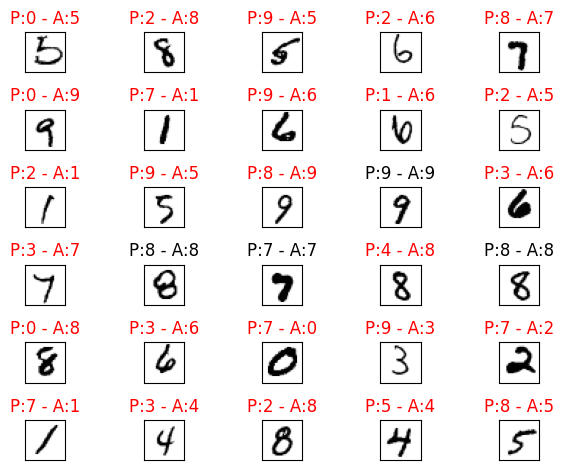

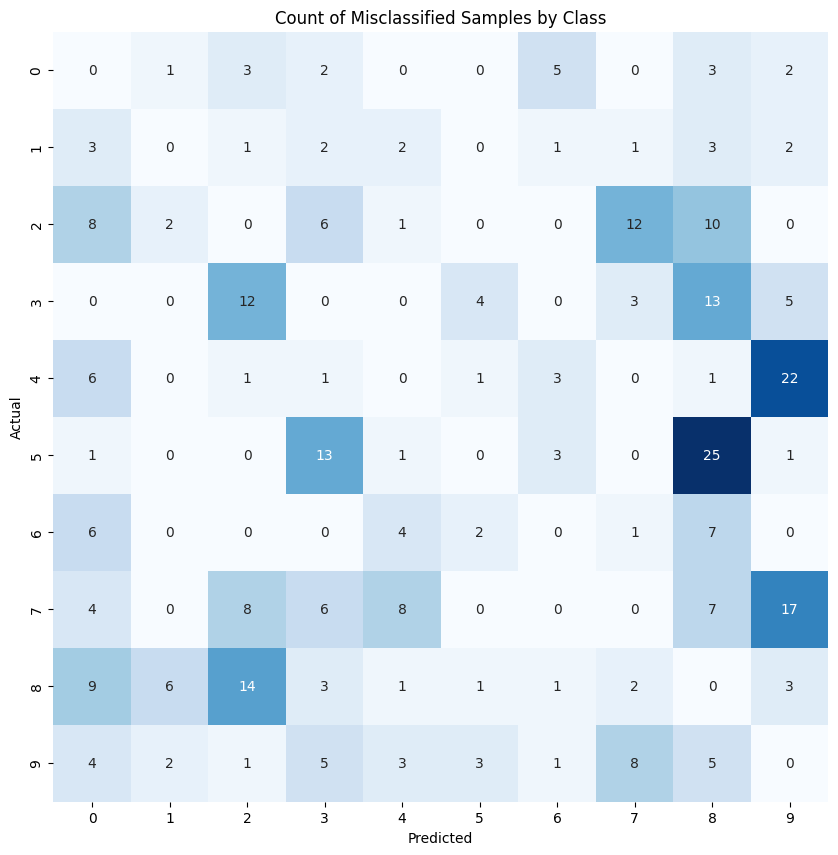

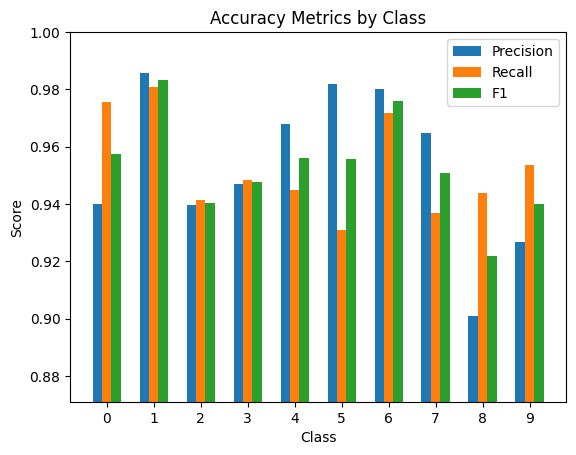

In [6]:
config = {
    'project': 'pytorch-demo',
    'tags': ['pytorch', 'demo'],
    'notes': 'First run with a simple CNN',
    'epochs': 5,
    'classes': 10,
    'kernels': [16, 32],
    'batch_size': 64,
    'learning_rate': 0.005,
    'dataset': 'MNIST',
    'architecture': 'CNN',
}
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)